# Mapping Tasiyagnunpa (Western Meadowlark) migration

Introduction to vector data operations

Tasiyagnunpa (or Western Meadowlark, or sturnella neglecta) migrates
each year to next on the Great Plains in the United States. Using
crowd-sourced observations of these birds, we can see that migration
happening throughout the year.

> Read more about the Lakota connection to Tasiyagnunpa from [Native Sun
> News
> Today](https://www.nativesunnews.today/articles/meadowlarks-still-speak-lakota-humans-dont-anymore/)

## Set up your reproducible workflow

### Import Python libraries

We will be getting data from a source called [GBIF (Global Biodiversity
Information Facility)](https://www.gbif.org/). We need a package called
`pygbif` to access the data, which is not included in your environment.
Install it by running the cell below:

In [9]:
%%bash
pip install pygbif

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your Task: Import packages**
>
> Add imports for packages that will help you:
>
> 1.  Work with tabular data
> 2.  Work with geospatial vector data
> 3.  Make an interactive plot of tabular and/or vector data

In [10]:
import calendar
import os
import pathlib
import requests
import time
import zipfile
from getpass import getpass

import cartopy.crs as ccrs
import panel as pn
import pygbif.occurrences as occ


import pandas as pd
import geopandas as gpd
import hvplot.pandas
import pygbif.species as species

### Create a folder for your data

For this challenge, you will need to save some data to your computer. We
suggest saving to somewhere in your *home* folder
(e.g. `/home/username`), rather than to your GitHub repository, since
data files can easily become too large for GitHub.

> **Warning**
>
> The **home** directory is different for every user! Your home
> directory probably won’t exist on someone else’s computer. Make sure
> to use code like `pathlib.Path.home()` to compute the home directory
> on the computer the code is running on. This is key to writing
> reproducible and interoperable code.

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your Task: Create a project folder**
>
> The code below will help you get started with making a project
> directory
>
> 1.  Replace `'your-project-directory-name-here'` and
>     `'your-gbif-data-directory-name-here'` with **descriptive** names
> 2.  Run the cell
> 3.  (OPTIONAL) Check in the terminal that you created the directory
>     using the command `ls ~/earth-analytics/data`

In [11]:
# Create data directory in the home folder
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'species-distribution',
)
os.makedirs(data_dir, exist_ok=True)

# Define the directory name for GBIF data
gbif_dir = os.path.join(data_dir, 'tasiyagnunpa_western_meadowlark')

## Define your study area – the ecoregions of North America

Track observations of Taciyagnunpa across the different **ecoregions**
of North America! You should be able to see changes in the number of
observations in each ecoregion throughout the year.

### Download and save ecoregion boundaries

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your Task**
>
> 1.  Find the URL for for the level III ecoregion boundaries. You can
>     [get ecoregion boundaries from the Environmental Protection Agency
>     (EPA).](https://www.epa.gov/eco-research/ecoregions-north-america).
> 2.  Replace `your/url/here` with the URL you found, making sure to
>     format it so it is easily readable.
> 3.  Change all the variable names to **descriptive** variable names
> 4.  Run the cell to download and save the data.

In [12]:
# Set up the ecoregions level III boundary URL
epa_url = ("https://gaftp.epa.gov/EPADataCommons/ORD/Ecoregions/cec_na/"
         "NA_CEC_Eco_Level3.zip")
# Set up a path to save the dataon your machine
epa_path = os.path.join(data_dir, 'NA_CEC_Eco_Level3.zip')

# Don't download twice
if not os.path.exists(epa_path):
    # Download, and don't check the certificate for the EPA
    a_response = requests.get(epa_url, verify=False)
    # Save the binary data to a file
    with open(epa_path, 'wb') as a_file:
        a_file.write(a_response.content)

### Load the ecoregions into Python

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task**
>
> Download and save ecoregion boundaries from the EPA:
>
> 1.  Replace `a_path` with the path your created for your ecoregions
>     file.
> 2.  (optional) Consider renaming and selecting columns to make your
>     `GeoDataFrame` easier to work with.
> 3.  Make a quick plot with `.plot()` to make sure the download worked.
> 4.  Run the cell to load the data into Python

<Axes: >

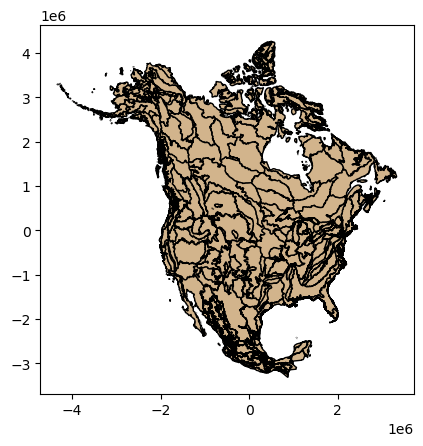

In [20]:
# Open up the ecoregions boundaries
epa_gdf = gpd.read_file(epa_path)

# Name the index so it will match the other data later on
epa_gdf.index.name = 'ecoregion'

# Plot the ecoregions to check download
epa_gdf.plot(edgecolor='black', color='tan')

### Create a simplified `GeoDataFrame` for plotting

Plotting larger files can be time consuming. The code below will
streamline plotting with `hvplot` by simplifying the geometry,
projecting it to a Mercator projection that is compatible with
`geoviews`, and cropping off areas in the Arctic.

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task**
>
> Download and save ecoregion boundaries from the EPA:
>
> 1.  Make a copy of your ecoregions `GeoDataFrame` with the `.copy()`
>     method, and save it to another variable name. Make sure to do
>     everything else in this cell with your new copy!
> 2.  Simplify the ecoregions with `.simplify(1000)`, and save it back
>     to the `geometry` column.
> 3.  Change the Coordinate Reference System (CRS) to Mercator with
>     `.to_crs(ccrs.Mercator())`
> 4.  Use the plotting code in the cell to check that the plotting runs
>     quickly and looks the way you want, making sure to change `gdf` to
>     YOUR `GeoDataFrame` name.

In [11]:
# Make a copy of the ecoregions

# Simplify the geometry to speed up processing

# Change the CRS to Mercator for mapping

# Check that the plot runs
gdf.hvplot(geo=True, crs=ccrs.Mercator())

## Access locations and times of Tasiyagnunpa encounters

For this challenge, you will use a database called the [Global
Biodiversity Information Facility (GBIF)](https://www.gbif.org/). GBIF
is compiled from species observation data all over the world, and
includes everything from museum specimens to photos taken by citizen
scientists in their backyards.

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task: Explore GBIF**
>
> Before your get started, go to the [GBIF occurrences search
> page](https://www.gbif.org/occurrence/search) and explore the data.

> **Contribute to open data**
>
> You can get your own observations added to GBIF using
> [iNaturalist](https://www.inaturalist.org/)!

### Register and log in to GBIF

You will need a [GBIF account](https://www.gbif.org/) to complete this
challenge. You can use your GitHub account to authenticate with GBIF.
Then, run the following code to save your credentials on your computer.

> **Tip**
>
> If you accidentally enter your credentials wrong, you can set
> `reset_credentials=True` instead of `reset_credentials=False`

In [13]:
reset_credentials = False
# GBIF needs a username, password, and email
credentials = dict(
    GBIF_USER=(input, 'GBIF username:'),
    GBIF_PWD=(getpass, 'GBIF password'),
    GBIF_EMAIL=(input, 'GBIF email'),
)
for env_variable, (prompt_func, prompt_text) in credentials.items():
    # Delete credential from environment if requested
    if reset_credentials and (env_variable in os.environ):
        os.environ.pop(env_variable)
    # Ask for credential and save to environment
    if not env_variable in os.environ:
        os.environ[env_variable] = prompt_func(prompt_text)

### Get the species key

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task**
>
> 1.  Replace the `species_name` with the name of the species you want
>     to look up
> 2.  Run the code to get the species key

In [14]:
# Query species
species_info = species.name_lookup(species_name, rank='SPECIES')

# Get the first result
first_result = species_info['results'][0]

# Get the species key (nubKey)
species_key = first_result['nubKey']

# Check the result
first_result['species'], species_key

### Download data from GBIF

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task**
>
> 1.  Replace `csv_file_pattern` with a string that will match **any**
>     `.csv` file when used in the `glob` function. HINT: the character
>     `*` represents any number of any values except the file separator
>     (e.g. `/`)
>
> 2.  Add parameters to the GBIF download function, `occ.download()` to
>     limit your query to:
>
>     -   Sturnella Neglecta observations
>     -   in north america (`NORTH_AMERICA`)
>     -   from 2023
>     -   with spatial coordinates.
>
> 3.  Then, run the download. **This can take a few minutes**.

In [16]:
# Only download once
gbif_pattern = os.path.join(gbif_dir, csv_file_pattern)
if not glob(gbif_pattern):
    # Submit query to GBIF
    gbif_query = occ.download([
        "continent = ",
        "speciesKey = ",
        "year = ",
        "hasCoordinate = ",
    ])
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]

        # Wait for the download to build
        wait = occ.download_meta(download_key)['status']
        while not wait=='SUCCEEDED':
            wait = occ.download_meta(download_key)['status']
            time.sleep(5)

    # Download GBIF data
    download_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'], 
        path=data_dir)

    # Unzip GBIF data
    with zipfile.ZipFile(download_info['path']) as download_zip:
        download_zip.extractall(path=gbif_dir)

# Find the extracted .csv file path
gbif_path = glob(gbif_pattern)[0]

### Load the GBIF data into Python

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task**
>
> 1.  Look at the beginning of the file you downloaded using the code
>     below. What do you think the **delimiter** is?
> 2.  Run the following code cell. What happens?
> 3.  Uncomment and modify the parameters of `pd.read_csv()` below until
>     your data loads successfully and you have only the columns you
>     want.

You can use the following code to look at the beginning of your file:

In [18]:
!head $gbif_path

In [19]:
# Load the GBIF data
gbif_df = pd.read_csv(
    gbif_path, 
    #delimiter='',
    #index_col='',
    #usecols=[]
)
gbif_df.head()

### Convert the GBIF data to a GeoDataFrame

To plot the GBIF data, we need to convert it to a `GeoDataFrame` first.

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task**
>
> 1.  Replace `your_dataframe` with the name of the `DataFrame` you just
>     got from GBIF
> 2.  Replace `longitude_column_name` and `latitude_column_name` with
>     column names from your \`DataFrame
> 3.  Run the code to get a `GeoDataFrame` of the GBIF data.

In [21]:
gbif_gdf = (
    gpd.GeoDataFrame(
        your_dataframe, 
        geometry=gpd.points_from_xy(
            your_dataframe.longitude_column_name, 
            your_dataframe.latitude_column_name), 
        crs="EPSG:4326")
    # Select the desired columns
    [[]]
)
gbif_gdf

## Count the number of observations in each ecosystem, during each month of 2023

### Identify the ecoregion for each observation

You can combine the ecoregions and the observations **spatially** using
a method called `.sjoin()`, which stands for spatial join.

> **<i class="fa fa-solid fa-glasses fa-large" aria-label="glasses"></i>
> Further reading**
>
> Check out the [`geopandas` documentation on spatial
> joins](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins)
> to help you figure this one out. You can also ask your favorite LLM
> (Large-Language Model, like ChatGPT)

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task**
>
> 1.  Identify the correct values for the `how=` and `predicate=`
>     parameters of the spatial join.
> 2.  Select only the columns you will need for your plot.
> 3.  Run the code.

In [23]:
gbif_ecoregion_gdf = (
    ecoregions_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='', 
        predicate='')
    # Select the required columns
    
)
gbif_ecoregion_gdf

### Count the observations in each ecoregion each month

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task:**
>
> 1.  Replace `columns_to_group_by` with a list of columns. Keep in mind
>     that you will end up with one row for each group – you want to
>     count the observations in each ecoregion by month.
> 2.  Select only month/ecosystem combinations that have more than one
>     occurrence recorded, since a single occurrence could be an error.
> 3.  Use the `.groupby()` and `.mean()` methods to compute the mean
>     occurrences by ecoregion and by month.
> 4.  Run the code – it will normalize the number of occurrences by
>     month and ecoretion.

In [25]:
occurrence_df = (
    gbif_ecoregion_gdf
    # For each ecoregion, for each month...
    .groupby(columns_to_group_by)
    # ...count the number of occurrences
    .agg(occurrences=('name', 'count'))
)

# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[...]

# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
    occurrence_df
    ...
)
# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
    ...
)

# Normalize the observations by the monthly mean throughout the year
occurrence_df['norm_occurrences'] = (
    occurrence_df.occurrences 
    / mean_occurrences_by_ecoregion
    / mean_occurrences_by_month
)
occurrence_df

## Plot the Tasiyagnunpa observations by month

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task**
>
> 1.  If applicable, replace any variable names with the names you
>     defined previously.
> 2.  Replace `column_name_used_for_ecoregion_color` and
>     `column_name_used_for_slider` with the column names you wish to
>     use.
> 3.  Customize your plot with your choice of title, tile source, color
>     map, and size.

In [27]:
# Join the occurrences with the plotting GeoDataFrame
occurrence_gdf = ecoregions_plot_gdf.join(occurrence_df)

# Get the plot bounds so they don't change with the slider
xmin, ymin, xmax, ymax = occurrence_gdf.total_bounds

# Plot occurrence by ecoregion and month
migration_plot = (
    occurrence_gdf
    .hvplot(
        c=column_name_used_for_shape_color,
        groupby=column_name_used_for_slider,
        # Use background tiles
        geo=True, crs=ccrs.Mercator(), tiles='CartoLight',
        title="Your Title Here",
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=600,
        widget_location='bottom'
    )
)

# Save the plot
migration_plot.save('migration.html', embed=True)

# Show the plot
migration_plot

::: {.content-visible when-format=“html”}
<embed type="text/html" src="migration.html" width="600" height="600">
:::

> **<i class="fa fa-solid fa-pepper-hot fa-large" aria-label="pepper-hot"></i>
> Want an EXTRA CHALLENGE?**
>
> Notice that the `month` slider displays numbers instead of the month
> name. Use `pn.widgets.DiscreteSlider()` with the `options=` parameter
> set to give the months names. You might want to try asking ChatGPT how
> to do this, or look at the documentation for
> `pn.widgets.DiscreteSlider()`. This is pretty tricky!